# GAMMA比赛多模态眼底图像数据集下基于EfficientNet和resnet构造fundus_img和oct_img的分类模型

作者信息：[Tomoko-hjf](https://github.com/Tomoko-hjf)

更新日期：2022 年 12 月 7 日

## 一、简要介绍

青光眼是一种不可逆的会导致视力下降的眼部疾病，及时地发现和诊断对青光眼的治疗至关重要。

在本任务中，我们的目的是分析`2D彩色眼底图像`和`3D OCT`扫描体数据两种模态的临床数据，根据视觉特征将样本分级为`无青光眼`、`早期青光眼`、`中或晚期青光眼`三个类别。

## 二、环境设置

导入`PaddlePaddle`和一些其他数据处理会用到的包，本教程基于`PaddlePaddle2.4.0`编写。

In [20]:
# 导入包
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm

import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.nn import Conv2D, MaxPool2D, AdaptiveAvgPool2D, Linear, ReLU, BatchNorm2D
import paddle.vision.transforms as trans

import warnings
warnings.filterwarnings('ignore')

print(paddle.__version__)

2.4.0


## 三、数据集

### 3.1 数据介绍

本项目使用的数据集来自2021 `MICCAI` 竞赛的`GAMMA`挑战赛任务一：多模态青光眼分级，该数据将青光眼分为`non`，`early`，`mid_advanced`三类。

数据集中包含200个两种临床模态影像的数据对，包括100对训练集，100对测试集。训练集中每对数据都包含一张常规的2D眼底彩照和一组3D光学相干断层扫描(OCT)两种模态的数据，每组3D图都由256张二维切片构成。

* 可以报名飞浆学习赛：[多模态青光眼分级](https://aistudio.baidu.com/aistudio/competition/detail/119/0/task-definition)获取数据
* 也可以通过挂载`Ai Studio`社区的官方数据集`grad`获取数据。

> 这里采用挂载飞浆官方数据集的方式。

### 3.2 解压数据集

执行如下解压命令，将数据集解压到本地。

In [ ]:
!tar -xf /home/aistudio/data/data128738/gamma_grading.tar

### 3.3 划分训练集和测试集

因为官方只给了100个训练集和100个测试集，为了在训练过程中验证模型准确度，所以需要将官方训练集进一步划分为训练集和验证集。这里我们按`8:2`进行了划分。

In [21]:
# 划分训练集和测试集的比例
val_ratio = 0.2 # 80 / 20
# 训练数据根目录
trainset_root = "Glaucoma_grading/training/multi-modality_images"
# 标签文件名
gt_file = 'Glaucoma_grading/training/glaucoma_grading_training_GT.xlsx'
# 测试数据根目录
testset_root = "Glaucoma_grading/testing/multi-modality_images"
# 读取所有训练数据文件名
filelists = os.listdir(trainset_root)
# 按照划分比例进行划分
train_filelists, val_filelists = train_test_split(filelists, test_size=val_ratio, random_state=42)
print("Total Nums: {}, train: {}, val: {}".format(len(filelists), len(train_filelists), len(val_filelists)))

Total Nums: 100, train: 80, val: 20


### 3.4 数据集类定义

定义自己的数据加载类`GAMMA_sub1_dataset`，该加载类继承了飞浆(PaddlePaddle)的`paddle.io.Dataset`父类，并实现了`__getitem__()`和`__len__()`方法。

In [22]:
class GAMMA_sub1_dataset(paddle.io.Dataset):

    def __init__(self,
                 img_transforms,
                 oct_transforms,
                 dataset_root,
                 label_file='',
                 filelists=None,
                 num_classes=3,
                 mode='train'):

        self.dataset_root = dataset_root
        self.img_transforms = img_transforms
        self.oct_transforms = oct_transforms
        self.mode = mode.lower()
        self.num_classes = num_classes
        # 如果是加载训练集，则需要加载label
        if self.mode == 'train':
            # 使用pandas读取label，label是one-hot形式
            label = {row['data']: row[1:].values
                     for _, row in pd.read_excel(label_file).iterrows()}

            self.file_list = [[f, label[int(f)]] for f in os.listdir(dataset_root) ]
        # 如果是加载测试集，则label为空
        elif self.mode == "test":
            self.file_list = [[f, None] for f in os.listdir(dataset_root)]

        # 如果指定了加载哪些数据，则只加载指定的数据
        if filelists is not None:
            self.file_list = [item for item in self.file_list if item[0] in filelists]

    def __getitem__(self, idx):
        # 或许指定下标的训练集和标签，real_index是样本所在的文件夹名称
        real_index, label = self.file_list[idx]
        # 彩色眼底图像的路径
        fundus_img_path = os.path.join(self.dataset_root, real_index, real_index + ".jpg")
        # 光学相干层析(OCT)图片的路径集，一个3D OCT图片包含256张二维切片 
        oct_series_list = sorted(os.listdir(os.path.join(self.dataset_root, real_index, real_index)), key=lambda s: int(s.split('_')[0]))
        # 使用opencv读取图片，并转换通道 BGR -> RGB
        fundus_img = cv2.imread(fundus_img_path)[:, :, ::-1] 
        # 读取3D OCT图片的一个切片，注意是灰度图 cv2.IMREAD_GRAYSCALE
        oct_series_0 = cv2.imread(os.path.join(self.dataset_root, real_index, real_index, oct_series_list[0]), cv2.IMREAD_GRAYSCALE)
        oct_img = np.zeros((oct_series_0.shape[0], oct_series_0.shape[1], len(oct_series_list)), dtype="uint8")
        # 依次读取每一个切片
        for k, p in enumerate(oct_series_list):
            oct_img[:, :, k] = cv2.imread(os.path.join(self.dataset_root, real_index, real_index, p), cv2.IMREAD_GRAYSCALE)
        
        # 对彩色眼底图片进行数据增强
        if self.img_transforms is not None:
            fundus_img = self.img_transforms(fundus_img)

        # 对3D OCT图片进行数据增强
        if self.oct_transforms is not None:
            oct_img = self.oct_transforms(oct_img)
        
        # 交换维度，变为[通道数，高，宽],  H, W, C -> C, H, W
        fundus_img = fundus_img.transpose(2, 0, 1)
        oct_img = oct_img.transpose(2, 0, 1)
        
        if self.mode == 'test':
            return fundus_img, oct_img, real_index
        if self.mode == "train":
            label = label.argmax()
            return fundus_img, oct_img, label

    # 获取数据集总的长度
    def __len__(self):
        return len(self.file_list)

### 3.5 数据增强操作

考虑到训练数据集较小，为了避免过拟合，可以使用`paddle.vision.transform`进行适当的水平翻转，垂直翻转，按比例裁剪等数据增强操作。

In [23]:
# 彩色眼底图片大小
image_size = [256, 256]
# 三维OCT图片每个切片的大小
oct_img_size = [512, 512]

# 数据增强操作
img_train_transforms = trans.Compose([
    # 按比例随机裁剪原图后放缩到对应大小
    trans.RandomResizedCrop(image_size, scale=(0.90, 1.1), ratio=(0.90, 1.1)),
    # 随机水平翻转
    trans.RandomHorizontalFlip(),
    # 随机垂直翻转
    trans.RandomVerticalFlip(),
    # 随机旋转
    trans.RandomRotation(30)
])

oct_train_transforms = trans.Compose([
    # 中心裁剪到对应大小
    trans.CenterCrop(oct_img_size),
    trans.RandomHorizontalFlip(),
    trans.RandomVerticalFlip()
])

img_val_transforms = trans.Compose([
    trans.Resize(image_size)
])

oct_val_transforms = trans.Compose([
    trans.CenterCrop(oct_img_size)
])

### 3.6 数据集抽取展示

fundus_size (3, 256, 256)
oct_size (512, 512)


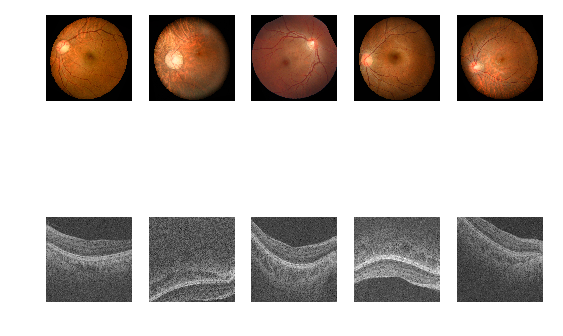

In [24]:
_train = GAMMA_sub1_dataset(dataset_root=trainset_root,
                        img_transforms=img_train_transforms,
                        oct_transforms=oct_train_transforms,
                        label_file=gt_file)

_val = GAMMA_sub1_dataset(dataset_root=trainset_root,
                        img_transforms=img_val_transforms,
                        oct_transforms=oct_val_transforms,
                        label_file=gt_file)
for i in range(5):
    fundus_img, oct_img, lab = _train.__getitem__(i)
    plt.subplot(2, 5, i+1)
    plt.imshow(fundus_img.transpose(1, 2, 0))
    plt.axis("off")
    plt.subplot(2, 5, i+6)
    # 展示灰度图
    plt.imshow(oct_img[100], cmap='gray')
    if i == 0:
        print('fundus_size', fundus_img.shape)
        print('oct_size', oct_img[100].shape)
    plt.axis("off")

## 四、模型组网

考虑到是多模态数据，所以使用了两个分支分别对数据进行训练，对于`彩色眼底图像`使用`EfficientNetB3`训练，对于`3D OCT`数据使用`resnet34`训练，然后将两个网络的输出特征共同输入分类头进行预测。

### 4.1 搭建EfficientNetB3网络分支

In [25]:
class ConvBNLayer(nn.Layer):
    def __init__(self, inchannels, outchannels, stride, kernelsize = 3, groups = 1, padding="SAME"):
        super(ConvBNLayer, self).__init__()
        padding = (kernelsize - 1) // 2
        self.conv = nn.Conv2D(
            in_channels=inchannels,
            out_channels=outchannels,
            kernel_size=kernelsize,
            stride=stride,
            padding=padding,
            groups=groups
            )
        self.bn = nn.BatchNorm2D(outchannels)
        self.Swish = nn.Swish()

    def forward(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.Swish(x)
        return x    

############ SE-Net ####################
class SE(nn.Layer):
    def __init__(self, inchannels):
        super(SE, self).__init__()
        self.pooling = nn.AdaptiveAvgPool2D(output_size=(1, 1))
        self.linear0 = nn.Conv2D(in_channels=inchannels,
                        out_channels=int(inchannels*0.25), 
                        kernel_size=1)
        self.linear1 = nn.Conv2D(in_channels=int(inchannels*0.25), 
                        out_channels=inchannels, 
                        kernel_size=1)
        self.Swish = nn.Swish()
        self.Sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        x = self.pooling(inputs)
        x = self.linear0(x)
        x = self.Swish(x)
        x = self.linear1(x)
        x = self.Sigmoid(x)
        out = paddle.multiply(x, inputs)
        
        return out 

############# MBConV ########################
class MBConv(nn.Layer):
    def __init__(self, inchannels, outchannels, channels_time, kernel_size, stride, connected_dropout):
        super(MBConv, self).__init__()
        self.stride = stride
        self.layer0 = ConvBNLayer(
            inchannels=inchannels,
            outchannels=inchannels*channels_time,
            kernelsize=1,
            stride=1,
            )
        self.layer1 = ConvBNLayer(
            inchannels=inchannels*channels_time,
            outchannels=inchannels*channels_time,
            kernelsize=kernel_size,
            stride=stride,
            groups=inchannels*channels_time
            )
        self.SE = SE(inchannels = inchannels*channels_time)
        self.conv0 = nn.Conv2D(
            in_channels=inchannels*channels_time,
            out_channels=outchannels,
            kernel_size=1
            )
        self.bn0 = nn.BatchNorm2D(outchannels)
        self.conv1 = nn.Conv2D(
            in_channels=inchannels,
            out_channels=outchannels,
            kernel_size=1
            )
        self.bn1 = nn.BatchNorm2D(outchannels)
        self.dropout = nn.Dropout(p=connected_dropout)

    def forward(self, inputs):
        y = inputs
        x = self.layer0(inputs)
        x = self.layer1(x)
        x = self.SE(x)
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.dropout(x)
        if self.stride == 2:
            return x          
        if self.stride == 1:
            y = self.conv1(inputs)
            y = self.bn1(y)
            return  paddle.add(x, y)

#############  Classifier_Head ######################
class Classifier_Head(paddle.nn.Layer):
    def __init__(self, in_channels, num_channel, dropout_rate):
        super(Classifier_Head, self).__init__()
        self.pooling = nn.AdaptiveAvgPool2D(output_size=(1, 1))
        self.conv = ConvBNLayer(inchannels=in_channels,
                                outchannels=1280,
                                kernelsize=1,
                                stride=1
                                )    
        self.dropout = nn.Dropout(p=dropout_rate) 
        self.conv1 = nn.Conv2D(
                in_channels=1280,
                out_channels=num_channel,
                kernel_size=1,
                padding="SAME"
                )
    
    def forward(self, inputs):
        x = self.conv(inputs)
        x = self.pooling(x)
        x = self.dropout(x)
        x = self.conv1(x)
        x = paddle.squeeze(x, axis=[2, 3])
        x = F.softmax(x)

        return x

###############  EffictNet ##################
class EfficientNet(nn.Layer):
    def __init__(self, in_channels, num_class, width_coefficient, depth_coefficient, connected_dropout, dropout_rate):
        super(EfficientNet, self).__init__()
        block_setting=[[0, 1, 3, 1, 1, 16],
                        [1, 2, 3, 2, 6, 24],
                        [2, 2, 5, 2, 6, 40],
                        [3, 3, 3, 2, 6, 80],
                        [4, 3, 5, 1, 6, 112],
                        [5, 4, 5, 2, 6, 192],
                        [6, 1, 3, 1, 6, 320]]
        self.block = []
        self.block.append(self.add_sublayer('c'+str(-1), nn.Conv2D(in_channels=in_channels,
                                                out_channels=int(32*width_coefficient),
                                                kernel_size=3,
                                                padding="SAME",
                                                stride=2)))
        self.block.append(self.add_sublayer('bn'+str(-1),nn.BatchNorm2D(int(32*width_coefficient))))
        i = int(32*width_coefficient)
        for j in range(int(depth_coefficient)-1):
            if  j==int(depth_coefficient)-2:
                self.block.append(self.add_sublayer('c'+str(j), nn.Conv2D(in_channels=i,
                                                out_channels=int(32*width_coefficient),
                                                kernel_size=3,
                                                padding="SAME",
                                                stride=2)))
                self.block.append(self.add_sublayer('bn'+str(j),nn.BatchNorm2D(int(32*width_coefficient))))
            else:
                self.block.append(self.add_sublayer('c'+str(j), nn.Conv2D(in_channels=i,
                                                out_channels=int(32*width_coefficient),
                                                kernel_size=3,
                                                padding="SAME")))
                self.block.append(self.add_sublayer('bn'+str(j),nn.BatchNorm2D(int(32*width_coefficient))))
        for n, r, k, s, e, o in block_setting:
            for j in range(int(r*depth_coefficient)):
                if j==int(r*depth_coefficient)-1:
                    self.block.append(self.add_sublayer('b'+str(n)+str(j), 
                                            MBConv(inchannels=i,
                                                outchannels=int(o*width_coefficient),
                                                channels_time=e,
                                                kernel_size=k,
                                                stride=s,
                                                connected_dropout=connected_dropout
                                                )))
                else:
                    self.block.append(self.add_sublayer('b'+str(n)+str(j), 
                                            MBConv(inchannels=i,
                                                outchannels=int(o*width_coefficient),
                                                channels_time=e,
                                                kernel_size=k,
                                                stride=1,
                                                connected_dropout=connected_dropout
                                                )))
                i = int(o*width_coefficient)
        self.head = Classifier_Head(in_channels=i,
                                    num_channel=num_class,
                                    dropout_rate=dropout_rate)

    def forward(self, x):
        for layer in self.block:
            x = layer(x)
        x = self.head(x)
        return x

def EfficientNetB3(in_channels, num_class):
    return EfficientNet(in_channels=in_channels, 
                        num_class=num_class,
                        width_coefficient=1.2,
                        depth_coefficient=1.4,
                        connected_dropout=0.2,
                        dropout_rate=0.3)

### 4.2 搭建ResNet网络分支

In [26]:
###### BasicBlock ###############
class Basicblock(paddle.nn.Layer):
    def __init__(self, in_channel, out_channel, stride = 1):
        super(Basicblock, self).__init__()
        self.stride = stride
        self.conv0 = Conv2D(in_channel, out_channel, 3, stride = stride, padding = 1)
        self.conv1 = Conv2D(out_channel, out_channel, 3, stride=1, padding = 1)
        self.conv2 = Conv2D(in_channel, out_channel, 1, stride = stride)
        self.bn0 = BatchNorm2D(out_channel)
        self.bn1 = BatchNorm2D(out_channel)
        self.bn2 = BatchNorm2D(out_channel)

    def forward(self, inputs):
        y = inputs
        x = self.conv0(inputs)
        x = self.bn0(x)
        x = F.relu(x)
        x = self.conv1(x)
        x = self.bn1(x)
        if self.stride == 2:
            y = self.conv2(y)
            y = self.bn2(y)
        z = F.relu(x+y)
        return z

############ BottoleNeckBlock ##############
class Bottleneckblock(paddle.nn.Layer):
    def __init__(self, inplane, in_channel, out_channel, stride = 1, start = False):
        super(Bottleneckblock, self).__init__()
        self.stride = stride
        self.start = start
        self.conv0 = Conv2D(in_channel, inplane, 1, stride = stride)
        self.conv1 = Conv2D(inplane, inplane, 3, stride=1, padding=1)
        self.conv2 = Conv2D(inplane, out_channel, 1, stride=1)
        self.conv3 = Conv2D(in_channel, out_channel, 1, stride = stride)
        self.bn0 = BatchNorm2D(inplane)
        self.bn1 = BatchNorm2D(inplane)
        self.bn2 = BatchNorm2D(out_channel)
        self.bn3 = BatchNorm2D(out_channel)

    def forward(self, inputs):
        y = inputs
        x = self.conv0(inputs)
        x = self.bn0(x)
        x = F.relu(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.start:
            y = self.conv3(y)
            y = self.bn3(y)
        z = F.relu(x+y)
        return z

###################  Resnet  #################
class Resnet(paddle.nn.Layer):
    def __init__(self, num, bottlenet, in_channels):
        super(Resnet, self).__init__()
        self.conv0 = Conv2D(in_channels, 64, 7, stride=2)
        self.bn = BatchNorm2D(64)
        self.pool1 = MaxPool2D(3, stride=2)
        if bottlenet:
            self.layer0 = self.add_bottleneck_layer(num[0], 64, start = True)
            self.layer1 = self.add_bottleneck_layer(num[1], 128)
            self.layer2 = self.add_bottleneck_layer(num[2], 256)
            self.layer3 = self.add_bottleneck_layer(num[3], 512)
        else:
            self.layer0 = self.add_basic_layer(num[0], 64, start = True)
            self.layer1 = self.add_basic_layer(num[1], 128)
            self.layer2 = self.add_basic_layer(num[2], 256)
            self.layer3 = self.add_basic_layer(num[3], 512)
        self.pool2 = AdaptiveAvgPool2D(output_size = (1, 1))

    def add_basic_layer(self, num, inplane, start = False):
        layer = []
        if start:
            layer.append(Basicblock(inplane, inplane))
        else:
            layer.append(Basicblock(inplane//2, inplane, stride = 2))
        for i in range(num-1):
            layer.append(Basicblock(inplane, inplane))
        return nn.Sequential(*layer)

    def add_bottleneck_layer(self, num, inplane, start = False):
        layer = []
        if start:
            layer.append(Bottleneckblock(inplane, inplane, inplane*4, start = True))
        else:
            layer.append(Bottleneckblock(inplane, inplane*2, inplane*4, stride = 2, start = True))
        for i in range(num-1):
            layer.append(Bottleneckblock(inplane, inplane*4, inplane*4))
        return nn.Sequential(*layer)

    def forward(self, inputs):
        x = self.conv0(inputs)
        x = self.bn(x)
        x = self.pool1(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)        
        x = self.pool2(x)
        x = paddle.squeeze(x, axis=[2, 3])
        return x 

def resnet34(in_channels=3):
    return Resnet([3, 4, 6, 3], bottlenet = False, in_channels=in_channels)

### 4.3 模型组装

构建双分支网络，使用`EfficientNetB3`训练`彩色眼底图片`，使用`resnet34`训练`3D OCT`图片，然后融合两个分支得到最终的预测结果。

In [28]:
class Model(nn.Layer):
    def __init__(self):
        super(Model, self).__init__()
        self.fundus_branch =  EfficientNetB3(in_channels=3, num_class=1000)
        self.oct_branch = resnet34(in_channels=256)
        # 最终的分类数为3
        self.decision_branch = nn.Linear(1512 , 3)

    def forward(self, fundus_img, oct_img):
        b1 = self.fundus_branch(fundus_img)
        b2 = self.oct_branch(oct_img)
        logit = self.decision_branch(paddle.concat([b1, b2], 1))

        return logit

### 4.4 模型可视化

In [29]:
model = Model()
paddle.summary(model, [(1, 3, 256, 256), (1, 256, 512, 512)])

---------------------------------------------------------------------------------
    Layer (type)          Input Shape          Output Shape         Param #    
     Conv2D-831        [[1, 3, 256, 256]]   [1, 38, 128, 128]        1,064     
   BatchNorm2D-636    [[1, 38, 128, 128]]   [1, 38, 128, 128]         152      
     Conv2D-832       [[1, 38, 128, 128]]   [1, 38, 128, 128]        1,482     
   BatchNorm2D-637    [[1, 38, 128, 128]]   [1, 38, 128, 128]         152      
      Swish-291       [[1, 38, 128, 128]]   [1, 38, 128, 128]          0       
   ConvBNLayer-196    [[1, 38, 128, 128]]   [1, 38, 128, 128]          0       
     Conv2D-833       [[1, 38, 128, 128]]   [1, 38, 128, 128]         380      
   BatchNorm2D-638    [[1, 38, 128, 128]]   [1, 38, 128, 128]         152      
      Swish-292       [[1, 38, 128, 128]]   [1, 38, 128, 128]          0       
   ConvBNLayer-197    [[1, 38, 128, 128]]   [1, 38, 128, 128]          0       
AdaptiveAvgPool2D-106 [[1, 38, 128, 12

{'total_params': 36436367, 'trainable_params': 36353075}

## 五、模型训练

10000次迭代，训练时间大概需要4小时。

In [ ]:
# 训练逻辑
def train(model, iters, train_dataloader, val_dataloader, optimizer, criterion, log_interval, eval_interval):
    iter = 0
    model.train()
    avg_loss_list = []
    avg_kappa_list = []
    best_kappa = 0.
    while iter < iters:
        for data in train_dataloader:
            iter += 1
            if iter > iters:
                break
            fundus_imgs = (data[0] / 255.).astype("float32")
            oct_imgs = (data[1] / 255.).astype("float32")
            labels = data[2].astype('int64')
            logits = model(fundus_imgs, oct_imgs)
            loss = criterion(logits, labels)
            for p, l in zip(logits.numpy().argmax(1), labels.numpy()):
                avg_kappa_list.append([p, l])

            loss.backward()
            optimizer.step()

            model.clear_gradients()
            avg_loss_list.append(loss.numpy()[0])

            if iter % log_interval == 0:
                avg_loss = np.array(avg_loss_list).mean()
                avg_kappa_list = np.array(avg_kappa_list)
                # 计算Cohen’s kappa分数
                avg_kappa = cohen_kappa_score(avg_kappa_list[:, 0], avg_kappa_list[:, 1], weights='quadratic')
                avg_loss_list = []
                avg_kappa_list = []
                print("[TRAIN] iter={}/{} avg_loss={:.4f} avg_kappa={:.4f}".format(iter, iters, avg_loss, avg_kappa))

            if iter % eval_interval == 0:
                avg_loss, avg_kappa = val(model, val_dataloader, criterion)
                print("[EVAL] iter={}/{} avg_loss={:.4f} kappa={:.4f}".format(iter, iters, avg_loss, avg_kappa))
                # 保存精度更好的模型
                if avg_kappa >= best_kappa:
                    best_kappa = avg_kappa
                    paddle.save(model.state_dict(), os.path.join("best_model_{:.4f}".format(best_kappa), 'model.pdparams'))
                model.train()

# 验证逻辑
def val(model, val_dataloader, criterion):
    model.eval()
    avg_loss_list = []
    cache = []
    with paddle.no_grad():
        for data in val_dataloader:
            fundus_imgs = (data[0] / 255.).astype("float32")
            oct_imgs = (data[1] / 255.).astype("float32")
            labels = data[2].astype('int64')

            logits = model(fundus_imgs, oct_imgs)
            for p, l in zip(logits.numpy().argmax(1), labels.numpy()):
                cache.append([p, l])

            loss = criterion(logits, labels)
            avg_loss_list.append(loss.numpy()[0])
            
    cache = np.array(cache)
    kappa = cohen_kappa_score(cache[:, 0], cache[:, 1], weights='quadratic')
    avg_loss = np.array(avg_loss_list).mean()

    return avg_loss, kappa

# 读取数据的线程数
num_workers = 4

# batch_size大小
batchsize = 2

# 总的迭代次数
iters = 1000

# 优化器类型
optimizer_type = "adam"

# 初始学习率
init_lr = 1e-4

# Dataset
train_dataset = GAMMA_sub1_dataset(dataset_root=trainset_root,
                        img_transforms=img_train_transforms,
                        oct_transforms=oct_train_transforms,
                        filelists=train_filelists,
                        label_file=gt_file)

val_dataset = GAMMA_sub1_dataset(dataset_root=trainset_root,
                        img_transforms=img_val_transforms,
                        oct_transforms=oct_val_transforms,
                        filelists=val_filelists,
                        label_file=gt_file)

# DataLoader
train_loader = paddle.io.DataLoader(
    train_dataset,
    num_workers=num_workers,
    batch_size=batchsize,
    shuffle=True,
    return_list=True,
    use_shared_memory=False
)

val_loader = paddle.io.DataLoader(
    val_dataset,
    batch_size=batchsize,
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

if optimizer_type == "adam":
    optimizer = paddle.optimizer.Adam(init_lr, parameters=model.parameters())

#----- 使用交叉熵作为损失函数 ------#
criterion = nn.CrossEntropyLoss()

#----- 训练模型 -----------------#
train(model, iters, train_loader, val_loader, optimizer, criterion, log_interval=10, eval_interval=50)

[TRAIN] iter=10/1000 avg_loss=1.7867 avg_kappa=0.0000
[TRAIN] iter=20/1000 avg_loss=1.3398 avg_kappa=-0.1935
[TRAIN] iter=30/1000 avg_loss=0.8882 avg_kappa=0.0795
[TRAIN] iter=40/1000 avg_loss=0.7513 avg_kappa=0.3617
[TRAIN] iter=50/1000 avg_loss=1.2739 avg_kappa=0.2340
...

> 注意：如果训练过程出现数据加载错误，可能是因为训练集文件夹下多了一个`.ipynb_checkpoints`文件，使用`rm -r .ipynb_checkpoints`命令删去即可。

## 六、模型预测

### 6.1 模型预测

In [18]:
# 加载训练权重
best_model_path = "./best_model_0.9344/model.pdparams"
model = Model()
para_state_dict = paddle.load(best_model_path)
model.set_state_dict(para_state_dict)
model.eval()

img_test_transforms = trans.Compose([
    trans.Resize(image_size)
])

oct_test_transforms = trans.Compose([
    trans.CenterCrop(oct_img_size)
])

test_dataset = GAMMA_sub1_dataset(dataset_root=testset_root, 
                        img_transforms=img_test_transforms,
                        oct_transforms=oct_test_transforms,
                        mode='test')

cache = []
for fundus_img, oct_img, idx in tqdm(test_dataset):
    fundus_img = fundus_img[np.newaxis, ...]
    oct_img = oct_img[np.newaxis, ...]

    fundus_img = paddle.to_tensor((fundus_img / 255.).astype("float32"))
    oct_img = paddle.to_tensor((oct_img / 255.).astype("float32"))
    logits = model(fundus_img, oct_img)
    cache.append([idx, logits.numpy().argmax(1)])

100%|██████████| 62/62 [13:47<00:00, 13.34s/it]


### 6.2 导出预测结果

将预测结果保存到`csv`文件中

In [19]:
submission_result = pd.DataFrame(cache, columns=['data', 'dense_pred'])
# 将预测结果写入DataFrame对象
submission_result['non'] = submission_result['dense_pred'].apply(lambda x: int(x[0] == 0))
submission_result['early'] = submission_result['dense_pred'].apply(lambda x: int(x[0] == 1))
submission_result['mid_advanced'] = submission_result['dense_pred'].apply(lambda x: int(x[0] == 2))
# 保存csv文件
submission_result[['data', 'non', 'early', 'mid_advanced']].to_csv("./submission_sub1.csv", index=False)

最后导出的csv文件就是最终的提交格式啦！

![](https://ai-studio-static-online.cdn.bcebos.com/6d15e379d6a8486aa4792946c97d07ae8aa0e2d45d6d488485cea27fe477b508)
